## Eigenfaces

This problem is a bit more challenging and as such, will not count as much on the HW (points wise). For more information on this problem, see my course notes.

While we are extremely good at distinguishing faces (most of us), different faces share much in common. We obviously have two eyes, a nose, etc.. But how can we get a compute to find a set of features that describe faces? And how can we use these to dimensionaly compress faces? One of the early techniques to do this utilized the SVD.

In the following, I have provided code to import ~2k faces from the Yale faces database. You will need to import some packages below. This imports the data into a 2339x192x192 matrix. The first index is the number of faces and the second indices are the size of the image in pixels (192x192). Since this type of 3D matrix is not of use to us, we will need to unwrap each 2D image into a 1D image of pixels. I have provided some utility functions below to unwrap the images into vectors and to reformat them into matrices. The vectors are useful for analysis while we need them in 2D matrix form for plotting the faces themselves. All linear algebra will happen on the 2339x36864 matrix (2D) of vector faces while all plotting will happen on the 2339x192x192 matrix (3D).

Your job is the following. We will be using the SVD to break this database of faces into features, discard less important features, and reconstruct the faces from these lower dimensional representations.

1) Just plot a face or two to get a sense of what these images look like.
2) Compute the "mean face". If each face is a 2D matrix, just calculate the mean of all the 2D matrices. Plot this just to get a sense of what it looks like.
3) Subtract that mean face from each individual face. This is mean centering. Plot a mean centered face just to get a sense of what it looks like.
4) Take this mean centered collection of faces and transform them from a 3D to a 2D matrix as discussed above. This is what we will need for the SVD.
5) Compute the SVD.
6) Plot the singular values. We are trying to see how quickly they decrease in magnitude.
7) Plot a few eigenfaces. Remember, the eigenfaces are the column vectors of V. To plot the n-th eigenface, extract the n-th column of V, reshape it into a 2D matrix, then plot that.
8) Now lets compress the data. We are only going to keep the first 500 dimensions of the SVD. We worked with this in one of the other HW problems so I won't go into as much detail here. Remove all but the first 500 columns of U and V, and all but the first 500 singular values of D. Recompute the SVD to get a new 2339x36864 matrix (2D) of faces. Note, that before computing the SVD, we subtracted the "mean face" from each face. The recomputed compressed SVD thus compresses these faces in the "mean centered" sense. To get true faces back, we need to take each recomputed face in this recomputed SVD, and add the mean face back to it. Lets call the original matrix of faces X and the new one Xstar (after adding the mean face back).
9) Lets look at the first face. Plot the first face contained in X and the first face contained in Xstar. You may have to reshape these back into a 2D (192x192) matrix for plotting. They should look very similar.

In [2]:
using Pkg
Pkg.activate("Faces_SVD_Env") # To use the correct environment
Pkg.status()

Pkg.add("Images")
Pkg.add("ImageFeatures")
Pkg.add("LinearAlgebra")
Pkg.add("BenchmarkTools")
Pkg.add("Plots")
Pkg.add("ImageView")

using Images, ImageFeatures 
using LinearAlgebra
using BenchmarkTools
using Plots
using Images
using ImageView

  Activating project at `~/Desktop/LinearAlgebra_HW_All/Faces_SVD_Env`


Status `~/Desktop/LinearAlgebra_HW_All/Faces_SVD_Env/Project.toml`
  [6e4b80f9] BenchmarkTools v1.5.0
  [92ff4b2b] ImageFeatures v0.5.2
  [86fae568] ImageView v0.12.1
  [916415d5] Images v0.26.0
  [91a5bcdd] Plots v1.40.2
  [37e2e46d] LinearAlgebra


   Resolving package versions...
  No Changes to `~/Desktop/LinearAlgebra_HW_All/Faces_SVD_Env/Project.toml`
  No Changes to `~/Desktop/LinearAlgebra_HW_All/Faces_SVD_Env/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Desktop/LinearAlgebra_HW_All/Faces_SVD_Env/Project.toml`
  No Changes to `~/Desktop/LinearAlgebra_HW_All/Faces_SVD_Env/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Desktop/LinearAlgebra_HW_All/Faces_SVD_Env/Project.toml`
  No Changes to `~/Desktop/LinearAlgebra_HW_All/Faces_SVD_Env/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Desktop/LinearAlgebra_HW_All/Faces_SVD_Env/Project.toml`
  No Changes to `~/Desktop/LinearAlgebra_HW_All/Faces_SVD_Env/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Desktop/LinearAlgebra_HW_All/Faces_SVD_Env/Project.toml`
  No Changes to `~/Desktop/LinearAlgebra_HW_All/Faces_SVD_Env/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Desktop/LinearAlge

In [3]:
# Pull in the data. This will produce a 2339x192x192 matrix where there are 
# 2339 images each of size 192x192.
dim = 192

raw_imgs = zeros(2339, dim, dim);
path_train = "./Faces_datasets/";
count = 1
for directory = readdir(path_train)
    if directory == ".DS_Store" # My computer puts this in my directory and we need to skip it.
        continue
    end
    
    for file = readdir(path_train*directory)
        # println(path_train*directory*"/"*file)
        raw_imgs[count,:,:] =  load(path_train*directory*"/"*file)
        count += 1
    end
end

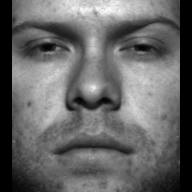

In [4]:
# Show one face
p1 = Gray.(raw_imgs[1,:,:]) 

In [5]:
# mean centering the daata 
mean_face = mean(raw_imgs, dims=1)

centered_imgs = raw_imgs .- mean_face

2339×192×192 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱  ⋮                        ⋮    
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.

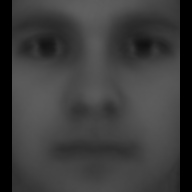

In [6]:
# Mean face
mean_face = mean(raw_imgs, dims=1)
mean_face = reshape(mean_face, 192, 192)
p2 = Gray.(mean_face)

In [7]:
# Utility functions. These functions convert the entire collection of faces back and forth at once.
# They do not convert them one face at a time.

# When we store a bank of images, each one of them needs to be converted from a 192x192 square 
# to a 1x36864 row vector. So we go from having a 3-Dim matrix to a 2-Dim matrix
function reshape_face_1D(matrix)
    dims = size(matrix)
    return reshape(matrix, (dims[1], dims[2]*dims[3]))
end

# After analysis, we will need to convert the image vectors back to image matrices for plotting.
# This takes the previous transform in reverse.
function reshape_face_2D(matrix)
    dims = size(matrix)
    return reshape(matrix, (dims[1], trunc(Int64, sqrt(dims[2])), trunc(Int64, sqrt(dims[2]))))
end

reshape_face_2D (generic function with 1 method)

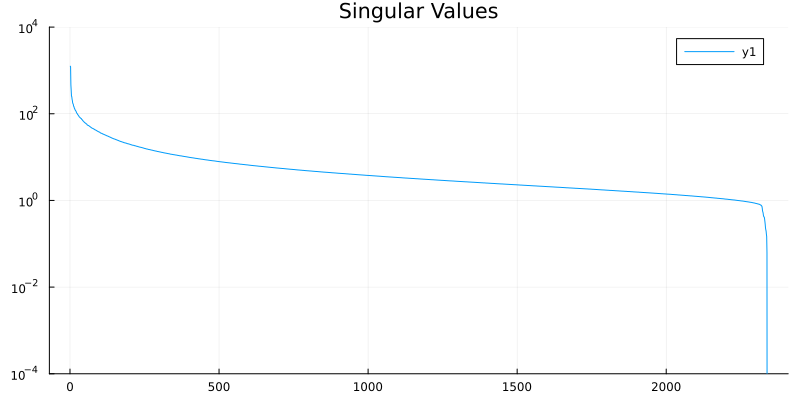

In [8]:
# reshape the 3D to 2D 
faces_2D = reshape_face_1D(centered_imgs)

# SVD
U, S, V = svd(faces_2D)

#  2D to 3D reshape
eigenfaces = reshape_face_2D(V'); 

p2 = plot(S, title="Singular Values",yscale=:log10, size=(800,400),ylimits = (10^-4,10^4))


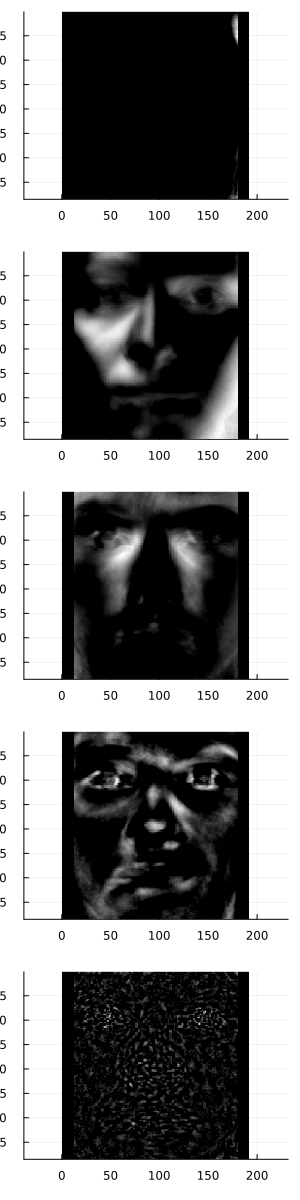

In [11]:
#  Plotting eigenfaces


function plot_eigenfaces(V, indices)
    eigenfaces_3D = reshape_face_2D(V')
    plots = []
    for i in indices
        eigenface = eigenfaces_3D[i,:,:]
        normalized_eigenface = Gray.(eigenface ./ maximum(eigenface))
        push!(plots, plot(normalized_eigenface))
    end
    plot(plots..., layout=(length(indices), 1), size=(300, 1200))
end

# Plot 2, 3, 100, 2100
plot_eigenfaces(V, [1, 5, 10, 50, 1000])


In [12]:
# Let's perform compression. We're going to keep the 500 largest singular values and eigenfaces.
# Truncate U, Σ, and V to 500 dimensions. Multiply these together. The resulting matrix is a compressed
# version of your raw faces. We need to reshape these reduced faces to 2D (for each face) and add the 
# previously subtracted mean face back on.

# Note that the svd function produces the singular values as a vector. You need to truncate this vector
# to 500 values, then turn it into a diagonal matrix. You can use the Diagonal() function for this.

n_eigen = 500
U_reduced = U[:, 1:n_eigen]
S_reduced = Diagonal(S[1:n_eigen])
V_reduced = V[:, 1:n_eigen]
X_reduced = U_reduced * S_reduced * V_reduced'
reduced_faces = reshape_face_2D(X_reduced);


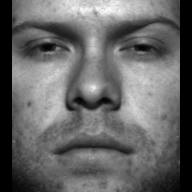

In [13]:

# Lets look at the first face. 
Gray.(raw_imgs[1,:,:]) # Plot the first face



# They should look very similar.

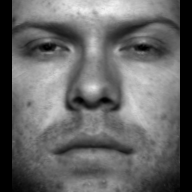

In [14]:
#Plot the first face contained in X and the first face contained in Xstar. You may have to reshape these back into a 2D (192x192) matrix for plotting.
Gray.(reduced_faces[1,:,:] .+ mean_face) # Plot the first reduced face